# Siamese Network with Optuna for Hyperparameter Optimization

### Manage dependencies

#### Install packages

In [1]:
!python -m pip install opencv-python matplotlib tensorflow==2.10

In [2]:
!conda install -c conda-forge cudatoolkit=11.8.0 --yes

Retrieving notices: ...working... done
Solving environment: ...working... done

## Package Plan ##

  environment location: e:\Code\CowId\.conda

  added / updated specs:
    - cudatoolkit=11.8.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2023.7.22          |     pyhd8ed1ab_0         150 KB  conda-forge
    cudatoolkit-11.8.0         |      h09e9e62_12       692.7 MB  conda-forge
    ------------------------------------------------------------
                                           Total:       692.9 MB

The following packages will be UPDATED:

  certifi                             2023.5.7-pyhd8ed1ab_0 --> 2023.7.22-pyhd8ed1ab_0 
  cudatoolkit                            11.8.0-h09e9e62_11 --> 11.8.0-h09e9e62_12 




certifi-2023.7.22    | 150 KB    |            |   0% 

cudatoolkit-11.8.0   | 692.7 MB  |            |   0% 

cudatoolkit-11.8.0   | 692.7 MB  |          



==> WARNING: A newer version of conda exists. <==
  current version: 23.1.0
  latest version: 23.5.2

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.5.2




In [3]:
!pip install nvidia-cudnn-cu11==8.6.0.163 --yes


Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: --yes


In [4]:
!pip install optuna

#### Check Nvidia-GPU installation

In [5]:
!python -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
!python -c "import tensorflow as tf; print(tf.reduce_sum(tf.random.normal([1000, 1000])))"

tf.Tensor(2697.0056, shape=(), dtype=float32)


2023-07-22 08:52:59.025377: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-22 08:52:59.964108: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9392 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


#### Import dependencies

In [1]:
import os
import cv2
import csv
import time
import random
import optuna
import datetime
import itertools
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess_input
from tensorflow.keras import layers, metrics, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.callbacks import TensorBoard
from sklearn.metrics import precision_score, recall_score, f1_score
from keras.utils import to_categorical

tf.__version__, np.__version__

e:\Code\CowId\.conda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


('2.10.0', '1.24.2')

### Set up environment

Set GPU growth to avoid OOM errors

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

Set Home path

In [3]:
HOME = os.path.split(os.getcwd())[0]
print(HOME)
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

e:\Code\CowId


Set data path

In [4]:
dataset_path = os.path.join(HOME, "data", "siamese_v7_augmented/train_val")

Setting random seeds to enable consistency while testing

In [5]:
random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)

### Siamese Model construction

Get ResNet or Xception encoder

In [6]:
def get_encoder(input_shape, encoder_architecture='resnet', dropout=0.5, l2_reg=0.5):
    if encoder_architecture == 'resnet':
        pretrained_model = ResNet152(
            input_shape=input_shape,
            weights='imagenet',
            include_top=False,
            pooling='avg',
        )
    
        for i in range(len(pretrained_model.layers)-12):
            pretrained_model.layers[i].trainable = False

        encode_model = Sequential([
            pretrained_model,
            layers.Flatten(),
            layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
            layers.Dropout(dropout),
            layers.BatchNormalization(),
            layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
            layers.Dropout(dropout),
            layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(l2_reg)),
            layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
        ], name="Encode_Model")
        
        return encode_model


    elif encoder_architecture == 'xception':
        pretrained_model = Xception(
            input_shape=input_shape,
            weights='imagenet',
            include_top=False,
            pooling='avg',
        )
        
        for i in range(len(pretrained_model.layers)-27):
            pretrained_model.layers[i].trainable = False

        encode_model = Sequential([
            pretrained_model,
            layers.Flatten(),
            layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
            layers.Dropout(dropout),
            layers.BatchNormalization(),
            layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
            layers.Dropout(dropout),
            layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
        ], name="Encode_Model")
        return encode_model

Distance layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²

In [7]:
class DistanceLayer(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

Creating Siamese Network Model

In [8]:
def get_siamese_network(input_shape = (128, 128, 3), encoder_architecture='resnet', dropout=0.5, l2_reg=0.5):
    encoder = get_encoder(input_shape, encoder_architecture, dropout, l2_reg)
    
    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")
    
    ## Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)
    
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(
        encoded_a,
        encoded_p,
        encoded_n
    )
    
    # Creating the Model
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network

Create entire Siamese Network

In [9]:
class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1.5):
        super(SiameseModel, self).__init__()
        
        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
            
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]

### Helper functions

Generates the triplets of anchor, positive, negative for all the cows

In [10]:
def generate_triplets(output_loc):
    if not os.path.exists(output_loc):
        os.makedirs(output_loc)    
    triplets = []
    cow_dirs = os.listdir(dataset_path)    
    for cow in cow_dirs:
        neg_dir_list = cow_dirs.copy()
        neg_dir_list.remove(cow)        
        all_cows_except_current = []        
        for neg_cow in neg_dir_list:
            neg_list = os.listdir(os.path.join(dataset_path, neg_cow))
            neg_list = list(map(lambda x: os.path.join(dataset_path, neg_cow, x), neg_list))
            all_cows_except_current.extend(neg_list)        
        path_to_cow = os.path.join(dataset_path, cow)        
        if "cow" in path_to_cow:
            pos_list = os.listdir(os.path.join(dataset_path, cow))
            pos_list = list(map(lambda x: os.path.join(dataset_path, cow, x), pos_list))            
            while len(pos_list) > 1 and len(all_cows_except_current) > 0:
                rand_pos_index = random.randrange(len(pos_list)) 
                positive_elem = pos_list.pop(rand_pos_index)                
                rand_anc_index = random.randrange(len(pos_list))
                anchor_elem = pos_list.pop(rand_anc_index)                
                rand_neg_index = random.randrange(len(all_cows_except_current))
                neg_elem = all_cows_except_current.pop(rand_neg_index)                
                triplets.append((positive_elem, anchor_elem, neg_elem))      
    print(len(triplets))    
    with open(os.path.join(output_loc, 'triplets.csv'), 'w', newline='') as file:
        writer = csv.writer(file)
        for row in triplets:
            writer.writerow(row)

Split dataset into train and test

In [42]:
def split_dataset(saving_route, percentage=0.2):
    dataset = []
    with open(os.path.join(saving_route, 'triplets.csv'), newline='') as file:
        reader = csv.reader(file)
        for row in reader:
            dataset.append(row)
    n = len(dataset)
    split_point = int(n * percentage)
    random.shuffle(dataset)
    train_set = dataset[:split_point] 
    test_set = dataset[split_point:]
    return train_set, test_set

Read image from path to memory

In [12]:
def read_image(path, target_size=(128, 128)):
    image = cv2.imread(path)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    return image

Get a batch of images to apply preprocessing

In [13]:
def get_batch(triplet_list, batch_size=64, preprocess=True, encoder_architecture='resnet'):
    batch_steps = len(triplet_list)//batch_size
    
    for i in range(batch_steps+1):
        anchor   = []
        positive = []
        negative = []
        
        j = i*batch_size
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p, n = triplet_list[j]
            if a.lower().endswith('.jpg') and p.lower().endswith('.jpg') and n.lower().endswith('.jpg'):
                anchor.append(read_image(a))
                positive.append(read_image(p))
                negative.append(read_image(n))
            j+=1
            
        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)
        
        if preprocess:
            if encoder_architecture == 'resnet':
                anchor = resnet_preprocess_input(anchor)
                positive = resnet_preprocess_input(positive)
                negative = resnet_preprocess_input(negative)
            elif encoder_architecture == 'xception':
                anchor = xception_preprocess_input(anchor)
                positive = xception_preprocess_input(positive)
                negative = xception_preprocess_input(negative)
        
        yield ([anchor, positive, negative])

Create encoder to save

In [14]:
def extract_encoder(model, encoder_architecture='resnet'):
    encoder = get_encoder((128, 128, 3), encoder_architecture=encoder_architecture)
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

Calculate the distance between two images

In [15]:
def calculate_distances(encoder, cows_list1, cows_list2):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(np.array(cows_list1))
    tensor2 = encoder.predict(np.array(cows_list2))

    # Calculate the Euclidean distance
    distance = np.sqrt(np.sum(np.square(tensor1 - tensor2), axis=-1))

    return distance

Classify if the cow images are the same

In [16]:
def classify_images(encoder, cows_list1, cows_list2, threshold=0.5):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(cows_list1)
    tensor2 = encoder.predict(cows_list2)
    
    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)
    print(prediction)
    return prediction

In [17]:
def create_prediction(encoder, val_triplets, threshold=0.5, encoder_architecture='resnet'):
    pos_list = np.array([])
    neg_list = np.array([])
    for data in get_batch(val_triplets, batch_size=64, preprocess=True, encoder_architecture=encoder_architecture):
        a, p, n = data
        pos_list = np.append(pos_list, classify_images(encoder, a, p, threshold))
        neg_list = np.append(neg_list, classify_images(encoder, a, n, threshold))
        
    y_true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    y_pred = np.append(pos_list, neg_list)
    return y_true, y_pred

### Model metrics

This function prints and plots the confusion matrix

In [18]:
def plot_confusion_matrix(true, pred, dir):
    
    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Similar','Different']
    names = ['True Similar','False Similar', 'False Different','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.clf()
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':12}, pad = 20)
    
    plt.tight_layout()  # Adjust layout

    plt.savefig(os.path.join(dir, 'confusion_matrix.png'))
    plt.clf()
    return f1_score(true, pred)

Plot training and validation metrics

In [19]:
def plot_metrics(history, save_path):
    plt.rcParams.update({'font.size': 14})  # Increase font size
    fig, axs = plt.subplots(2, figsize=(12, 10))  # Increase figure size

    # create accuracy subplot
    axs[0].plot(history['train_acc'], label='Train Accuracy', linewidth=2)  # Increase line width
    axs[0].plot(history['val_acc'], label='Validation Accuracy', linewidth=2)  # Increase line width
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc='lower right')
    axs[0].set_title("Accuracy Evaluation")
    axs[0].grid(True)  # Add grid for better visibility of values

    # create loss subplot
    axs[1].plot(history['train_loss'], label='Train Loss', linewidth=2)  # Increase line width
    axs[1].plot(history['val_loss'], label='Validation Loss', linewidth=2)  # Increase line width
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc='upper right')
    axs[1].set_title("Loss Evaluation")
    axs[1].grid(True)  # Add grid for better visibility of values

    # Improve layout
    plt.tight_layout()
    
    plt.savefig(os.path.join(save_path, 'metrics_plot.png'))
    plt.close()


Validation test metrics

In [20]:
def test_on_triplets(val_triplets, siamese_model, batch_size = 256, encoder_architecture='resnet'):
    pos_scores, neg_scores = [], []

    for data in get_batch(val_triplets, batch_size=batch_size, preprocess=True, encoder_architecture=encoder_architecture):
        prediction = siamese_model.predict(data)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])
    
    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)
    
    print(f"Accuracy on validation = {accuracy:.5f}")
    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)

Create logs

In [21]:
def named_logs(model, logs):
    result = {}
    for l in zip(model.metrics_names, logs):
        result[l[0]] = l[1]
    return result

### Model Training

Set saving path

In [22]:
saving_route = os.path.join(HOME, 'data', 'siamese_triplets_lists')

Create triplets list

In [23]:
generate_triplets(saving_route)

14652


Split triplets set into validation and training

In [23]:
train_triplets, val_triplets = split_dataset(saving_route, 0.2)

Check triplets construction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

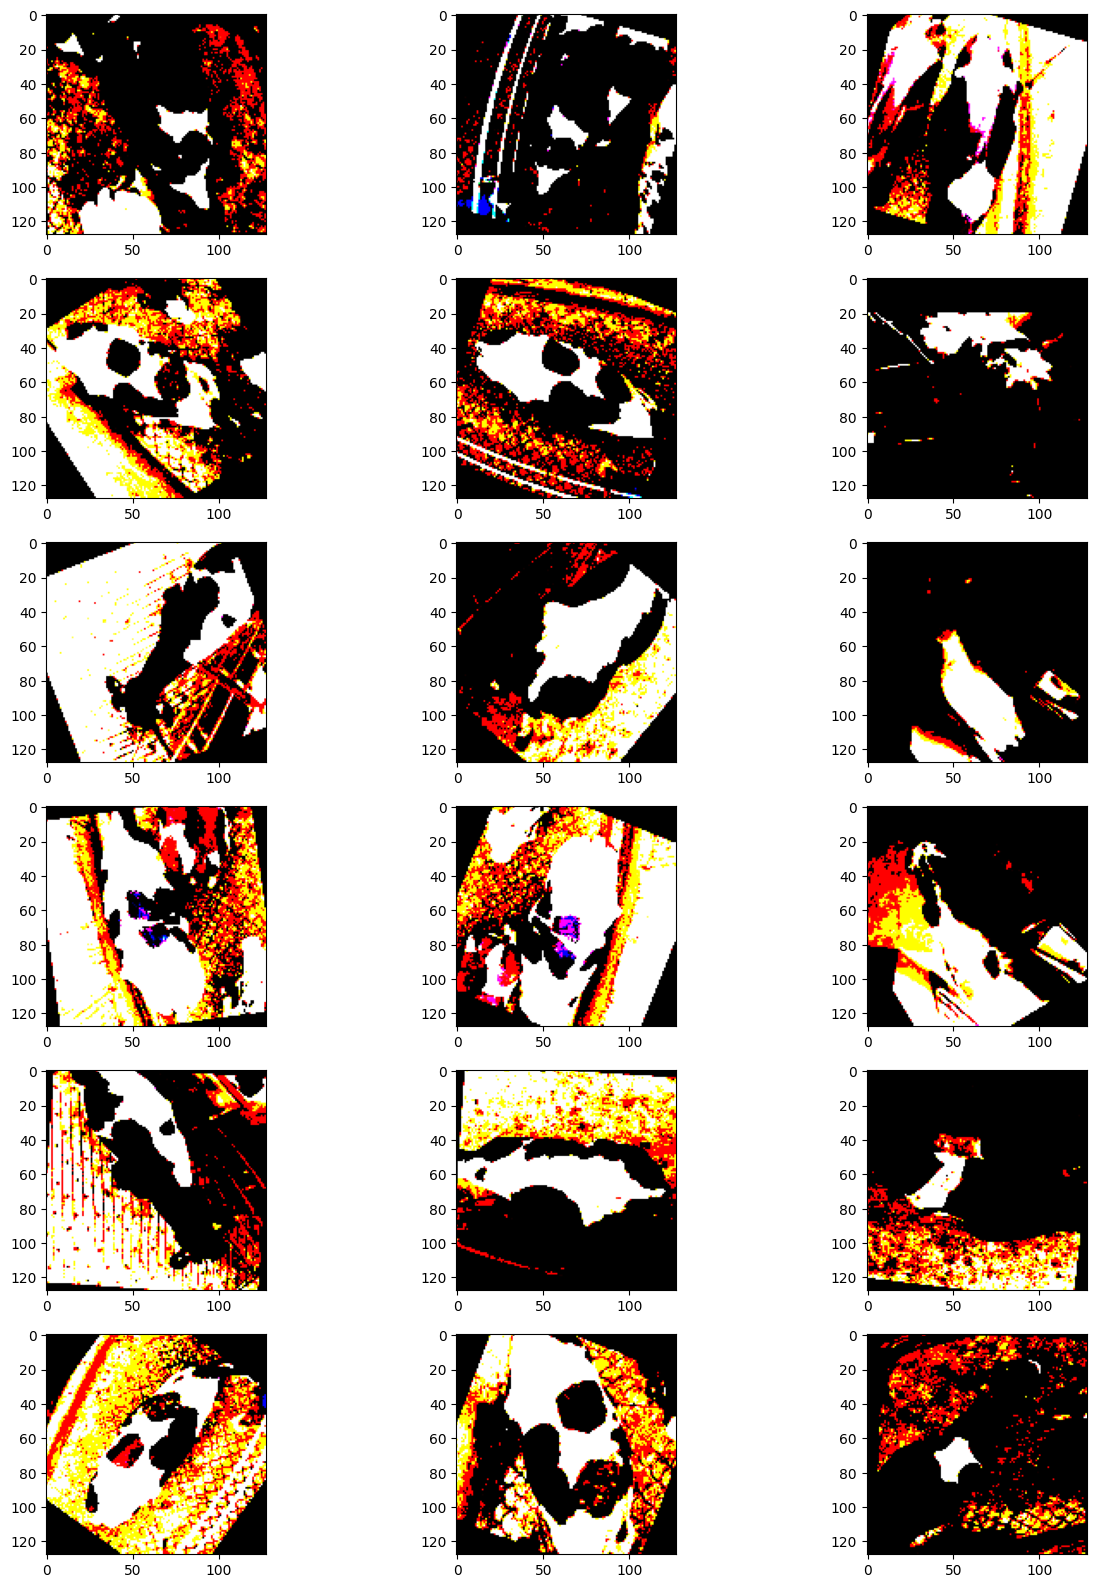

In [24]:
num_plots = 6

f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))

for x in get_batch(train_triplets, batch_size=num_plots, preprocess=True, encoder_architecture='resnet'): 
    a,p,n = x
    for i in range(num_plots):
        axes[i, 0].imshow(a[i])
        axes[i, 1].imshow(p[i])
        axes[i, 2].imshow(n[i])
    break

Handle Optuna runs folder structure

In [25]:
store_folder = 'optuna_siamese_runs'

folder_names = [int(name) for name in os.listdir(os.path.join(HOME, 'data', store_folder)) if os.path.isdir(os.path.join(HOME, 'data', store_folder, name))]
sorted_folders = sorted(folder_names, reverse=True)

OPTUNA_RUN_ITERATION = 0 if len(sorted_folders) == 0 else sorted_folders[0]

Define Optuna training objective

In [44]:
def objective(trial):
    global OPTUNA_RUN_ITERATION
    OPTUNA_RUN_ITERATION += 1
    OPTUNA_DIR = os.path.join(HOME, 'data', store_folder, str(OPTUNA_RUN_ITERATION))

    if not os.path.exists(OPTUNA_DIR): 
        os.makedirs(OPTUNA_DIR)

    # TensorBoard callback
    log_dir = os.path.join(OPTUNA_DIR, "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    param_grid = {
                  "ARCHITECTURE": 'xception', # trial.suggest_categorical("ARCHITECTURE", ["resnet", "xception"]), 
                  "LR": -4, # trial.suggest_int("LR", -5, -3, step=1), 
                  'E': -3, # trial.suggest_int("E", -4, -2, step=1), 
                  'EPOCHS': 40, #trial.suggest_int("EPOCHS", 20, 30, step=10),
                  'BATCH_SIZE': 32,
                  "DROPOUT": 0.6,
                  "L2_REG": 0.6
                  }

    LR = 10**param_grid["LR"]
    E = 10**param_grid["E"]
    EPOCHS = param_grid["EPOCHS"]
    BATCH_SIZE = param_grid["BATCH_SIZE"]
    
    siamese_network = get_siamese_network(encoder_architecture=param_grid["ARCHITECTURE"], dropout=param_grid["DROPOUT"], l2_reg=param_grid["L2_REG"])

    siamese_model = SiameseModel(siamese_network)

    optimizer = Adam(learning_rate=LR, epsilon=E)

    with open(os.path.join(HOME, 'data', OPTUNA_DIR, 'params.json'), 'w') as f:
        json.dump(param_grid, f)

    siamese_model.compile(optimizer=optimizer)

    history = {
        'train_acc': [],
        'val_acc': [],
        'train_loss': [],
        'val_loss': []
    }

    patience = 20
    best_metric = np.inf
    max_loss = np.inf
    epochs_no_improve = 0 

    for epoch in range(1, EPOCHS+1):
        t = time.time()
        print(f"Started training EPOCH {epoch}")

        # Training the model on train data
        epoch_loss, epoch_acc = [], []
        for data in get_batch(train_triplets, batch_size=BATCH_SIZE, preprocess=True, encoder_architecture=param_grid["ARCHITECTURE"]):
            # Compute the loss for this batch
            loss = siamese_model.train_on_batch(data)
            # Get predictions from the model
            pos_scores, neg_scores = siamese_model.predict(data)
            # Accuracy is calculated as the ratio of correct predictions
            correct_preds = np.sum(np.array(pos_scores) < np.array(neg_scores))
            acc = correct_preds / len(pos_scores)
            # Append the loss and accuracy to the respective lists
            epoch_loss.append(loss)
            epoch_acc.append(acc)
            
        epoch_loss = sum(epoch_loss)/len(epoch_loss)
        epoch_acc = sum(epoch_acc)/len(epoch_acc)

        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)

        print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
        print(f"Loss on train    = {epoch_loss:.5f}")
        print(f"Accuracy on train = {epoch_acc:.5f}")

        # Testing the model on test data
        metric = test_on_triplets(val_triplets, siamese_model, batch_size=BATCH_SIZE, encoder_architecture=param_grid["ARCHITECTURE"])
        val_loss, val_acc = metric[1], metric[0]  # assuming loss is the second value in the metric tuple

        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        if val_loss <= max_loss:
            siamese_model.save_weights(os.path.join(OPTUNA_DIR, "siamese_model")) 
            max_loss = val_loss

        # Replace the line checking for improvement:
        if val_loss < best_metric:
            best_metric = val_loss
            epochs_no_improve = 0  # reset the counter
        else:
            epochs_no_improve += 1

        # In the early stopping check replace this line:
        if epochs_no_improve == patience:
            print(f'Early stopping: Model did not improve below {best_metric:.5f} for {patience} epochs')
            break

    # Save the model after all epochs run
    siamese_model.save_weights(os.path.join(OPTUNA_DIR, "siamese_model-final")) 


    plot_metrics(history, OPTUNA_DIR)

    encoder = extract_encoder(siamese_model, encoder_architecture=param_grid["ARCHITECTURE"])
    encoder.save_weights(os.path.join(OPTUNA_DIR, "encoder"))
    encoder.save(os.path.join(OPTUNA_DIR, "encoder.h5"))


    # Iterate over possible thresholds to find the best
    best_f1 = 0
    best_threshold = 0

    for threshold in np.arange(0.1, 1.4, 0.2):
        y_true, y_pred = create_prediction(encoder, val_triplets, threshold, encoder_architecture=param_grid["ARCHITECTURE"])
        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    y_true, y_pred = create_prediction(encoder, val_triplets, best_threshold, encoder_architecture=param_grid["ARCHITECTURE"])
        
    f1 = plot_confusion_matrix(y_true, y_pred, os.path.join(OPTUNA_DIR))

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    metrics = {
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "best_threshold": best_threshold,
    }

    with open(os.path.join(HOME, 'data', OPTUNA_DIR, 'metrics.json'), 'w') as f:
        json.dump(metrics, f)

    # Memory cleanup
    del siamese_model
    del encoder
    del history
    tf.keras.backend.clear_session()
    gc.collect()

    return f1

Call optuna training loop

In [45]:
study = optuna.create_study(directions=['maximize'], storage=f"sqlite:///{os.path.join(HOME, 'data', 'siames.db')}", load_if_exists=True)
study.optimize(objective, n_trials=1)

%%notify
print('Finished!')

[I 2023-07-26 18:34:46,148] A new study created in RDB with name: no-name-8a9f4ce4-2749-43dc-a176-5057ee6e3bc1


Started training EPOCH 1
1/1 [==============================] - 1s 1s/step

EPOCH: 1 	 (Epoch done in 76 sec)
Loss on train    = 0.74661
Accuracy on train = 0.87704
1/1 [==============================] - 0s 24ms/step
Accuracy on validation = 0.89660
Started training EPOCH 2
1/1 [==============================] - 0s 22ms/step

EPOCH: 2 	 (Epoch done in 21 sec)
Loss on train    = 0.40367
Accuracy on train = 0.94599
1/1 [==============================] - 0s 22ms/step
Accuracy on validation = 0.95589
Started training EPOCH 3
1/1 [==============================] - 0s 21ms/step

EPOCH: 3 	 (Epoch done in 19 sec)
Loss on train    = 0.23227
Accuracy on train = 0.98098
1/1 [==============================] - 0s 23ms/step
Accuracy on validation = 0.96502
Started training EPOCH 4
1/1 [==============================] - 0s 21ms/step

EPOCH: 4 	 (Epoch done in 19 sec)
Loss on train    = 0.14907
Accuracy on train = 0.99253
1/1 [==============================] - 0s 23ms/step
Accuracy on validation = 0.

[I 2023-07-26 19:22:17,956] Trial 0 finished with value: 0.9479468651291593 and parameters: {}. Best is trial 0 with value: 0.9479468651291593.
UsageError: Line magic function `%%notify` not found.


<Figure size 640x480 with 0 Axes>

Finished!


<IPython.core.display.Javascript object>